In [192]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML  # type: ignore
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
import importlib
import itertools

# Import utility functions from custom modules
import utils.matrix as matrix_utils
import utils.plot as plot_utils
import utils.signals as signals_utils

importlib.reload(plot_utils)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
plot_utils.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 75

LaTeX has been enabled for text rendering.


In [193]:
def get_A(p):
  A11 = 0.
  A12 = 1.
  A21 = -10
  A22 = 0.5 - p[0]

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p):
  B11 = 0.
  B21 = 1.
  return np.array([[B11],
                   [B21]])


def get_E(p):
  E11 = 0
  E21 = 1.
  return np.array([[E11],
                   [E21]])

In [194]:
def system_update(time, states, inputs, params):

  u = np.array([[inputs[0]]])
  p = np.array([inputs[1]])
  w = np.array([[inputs[2]]])

  x = states.reshape(-1, 1)

  A = get_A(p)
  B = get_B(p)
  E = get_E(p)

  x_dot = A @ x + B @ u + E @ w

  if (time % 0.01 <= 1e-9):
    print(f't: {time:.3f}')

  return x_dot


plant = ct.nlsys(system_update, None, name="plant",
                 inputs=['u', 'p', 'w'], outputs=['x1', 'x2'],
                 states=['x1', 'x2'])

In [ ]:
step = 1e-5
end_time = 15.
timepts = np.arange(0, end_time + step, step)
freq = 1

u = np.zeros((1, len(timepts)))
# Parâmetros do sinal
freq = 1.0  # Frequência principal do ciclo
mod_freq = 0.2  # Frequência do padrão de diminuição e aumento

# Construção do sinal
p = 0.5 + 0.5 * np.cos(2 * np.pi * mod_freq * timepts) * \
    np.sin(2 * np.pi * freq * timepts)

# Garantir que o sinal está limitado entre 0 e 1
p = np.clip(p, 0, 1)

# Parâmetros dos sinais
decay_rate = 2.0  # Taxa de decaimento
freq = 1.0  # Frequência da senoide
start_points = [6.0, 10.0]  # Pontos de início dos sinais
amplitudes = [6.0, -4.]  # Amplitudes dos sinais

# Inicializar o sinal composto
w = np.zeros_like(timepts)

# Gerar os sinais de acordo com os parâmetros
for start, amplitude in zip(start_points, amplitudes):
  # Tempo deslocado (somente após 'start')
  shifted_timepts = np.maximum(timepts - start, 0)
  signal = amplitude * np.exp(-decay_rate * shifted_timepts) * \
      np.sin(2 * np.pi * freq * shifted_timepts)

  # Somar ao sinal composto
  w += signal

# Normalizar para energia limitada (se necessário)
w /= np.sqrt(np.sum(w**2) * step)

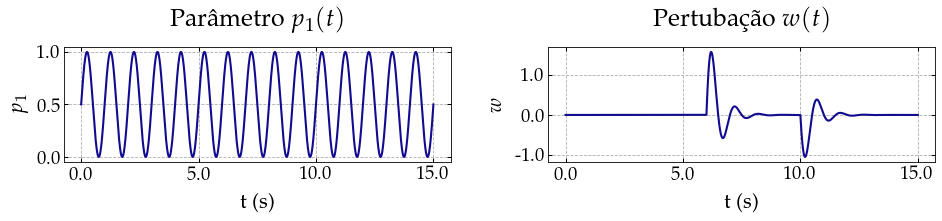

In [196]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    timepts, p,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)

plot_utils.set_subplot(
    axs[1],
    timepts, w.reshape(-1, 1),
    't (s)',
    '$w$',
    'Pertubação $w(t)$',
)

In [197]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u, p, w,],
    X0=[-0.5, 0.5]
)

t: 0.000
t: 15.000
t: 15.000


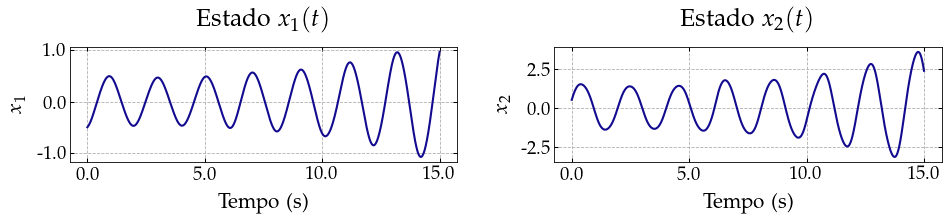

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    t, y[0],
    'Tempo (s)',
    '$x_1$',
    'Estado $x_1(t)$',
)

plot_utils.set_subplot(
    axs[1],
    t, y[1],
    'Tempo (s)',
    '$x_2$',
    'Estado $x_2(t)$',
)

In [199]:
def He(M): return M + M.T


p_bounds = [[0, 1.]]
φ_bounds = np.array([[4.5]])

B1 = list(itertools.product([0, 1], repeat=1))
B1plus = B1


A = {}
B = {}
E = {}

for i in B1:
  p = [p_bounds[0][i[0]]]
  A[i] = cp.Parameter((2, 2), name=f'A[{i}]', value=get_A(p))
  B[i] = cp.Parameter((2, 1), name=f'B[{i}]', value=get_B(p))
  E[i] = cp.Parameter((2, 1), name=f'E[{i}]', value=get_E(p))

h = 10e-3
ε = 0.1

e = {}
n = 2
_es = np.eye(n)
_ef = np.zeros((n, 6 * n))
e[1] = np.block([[_es, _ef, np.zeros((2, 2))]])
e[7] = np.block([[_ef, _es, np.zeros((2, 2))]])

for i in range(2, 7):
  e[i] = np.block([[np.zeros((n, n * (i - 1))),
                    np.eye(n),
                    np.zeros((n, n * (7 - i))),
                    np.zeros((n, 2))]])


e[8] = np.block([[np.zeros((1,  7 * n)), np.eye(1), np.zeros((1, 1))]])
e[9] = np.block([[np.zeros((1,  7 * n)), np.zeros((1, 1)), np.eye(1)]])

Ptil = {}
Stil = {}
Mtil = {}
for i in B1:
  Ptil[i] = cp.Variable((2, 2), symmetric=True)
  Stil[i] = cp.Variable((2, 2), symmetric=True)
  Mtil[i] = cp.Variable((2, 2))

Ktil = {}

for i in B1:
  Ktil[i] = cp.Variable((1, 2), name=f'K[{i}]')

Qtil = cp.Variable((2, 2), PSD=True)
Rtil = cp.Variable((2, 2), PSD=True)
Ξtil = cp.Variable((2, 2), PSD=True)
Ψtil = cp.Variable((2, 2), symmetric=True)
Gcal = cp.Variable((1, 2))
ℵ = cp.Variable((1, 1), diag=True)
γ = cp.Variable(pos=True)


X = cp.Variable((2, 2))
Y1til = cp.Variable((4, 4))
Y2til = cp.Variable((4, 4))

Rcal = cp.bmat([[Rtil, np.zeros((2, 2))],
                [np.zeros((2, 2)), 3. * Rtil]])

Xcal = e[1].T + ε * e[2].T + ε * e[3].T

Π = np.bmat([[e[1] - e[3]],
             [e[1] + e[3] - 2 * e[5]],
             [e[3] - e[4]],
             [e[3] + e[4] - 2 * e[6]]])

κ0 = cp.bmat([[e[2]], [e[1] - e[4]]])

κ1 = {}
κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

constraints = []

for i in B1:
  Pcal = cp.bmat([[Ptil[i], Mtil[i]],
                  [Mtil[i].T, Stil[i]]])
  constraints += [Pcal >> 0]
  constraints += [Ptil[i] >> 0]


def get_Λ(i, j):
  Pcal = cp.bmat([[Ptil[i], Mtil[i]],
                  [Mtil[i].T, Stil[i]]])
  Ytil = A[i] @ X @ e[1] - X @ e[2] + \
      B[i] @ Ktil[j] @ e[3] + B[i] @ Ktil[j] @ e[7] - \
      B[i] @ ℵ @ e[8] + E[i] @ e[9]

  Θtil = {}
  Θtil['0'] = 2 * (κ1['0'].T @ Pcal @ κ0) + e[1].T @ Qtil @ e[1] - \
      e[4].T @ Qtil @ e[4] + h ** 2 * e[2].T @ Rtil @ e[2] - \
      e[7].T @ Ξtil @ e[7] + He(Xcal @ Ytil) + e[8].T @ Gcal @ e[1] + \
      κ1['0'].T @ (φ_bounds[0] * Pcal) @ κ1['0'] - \
      γ * e[9].T @ e[9] + 2 * e[8].T @ ℵ @ e[8]

  Θtil['h'] = 2 * (κ1['h'].T @ Pcal @ κ0) + e[1].T @ Qtil @ e[1] - \
      e[4].T @ Qtil @ e[4] + h ** 2 * e[2].T @ Rtil @ e[2] - \
      e[7].T @ Ξtil @ e[7] + He(Xcal @ Ytil) + e[8].T @ Gcal @ e[1] + \
      κ1['h'].T @ (φ_bounds[0] * Pcal) @ κ1['h'] - \
      γ * e[9].T @ e[9] + 2 * e[8].T @ ℵ @ e[8]

  Φtil = {}

  Φtil1 = cp.bmat([[Rcal, np.zeros((4, 4))], [np.zeros((4, 4)), Rcal]])
  Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, np.zeros((4, 4))]])
  Φtil3 = cp.bmat([[np.zeros((4, 4)), Y1til], [Y1til.T, Rcal]])

  Φtil['0'] = Φtil1 + Φtil2
  Φtil['h'] = Φtil1 + Φtil3

  Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
  Γ1_12 = Π.T @ cp.bmat([[Y1til.T], [np.zeros((4, 4))]])
  Γ1_13 = e[3].T @ X
  Γ1_15 = e[1].T @ X

  Γ1_21 = Γ1_12.T
  Γ1_22 = - Rcal
  Γ1_23 = np.zeros((4, 2))
  Γ1_25 = np.zeros((4, 2))

  Γ1_31 = Γ1_13.T
  Γ1_32 = Γ1_23.T
  Γ1_33 = - Ψtil
  Γ1_35 = np.zeros((2, 2))

  Γ1_51 = Γ1_15.T
  Γ1_52 = Γ1_25.T
  Γ1_53 = Γ1_35.T
  Γ1_55 = - np.eye(2)

  Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13, Γ1_15],
                [Γ1_21, Γ1_22, Γ1_23, Γ1_25],
                [Γ1_31, Γ1_32, Γ1_33, Γ1_35],
                [Γ1_51, Γ1_52, Γ1_53, Γ1_55]])

  Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
  Γ2_12 = Π.T @ cp.bmat([[Y1til.T], [np.zeros((4, 4))]])
  Γ2_13 = e[3].T @ X
  Γ2_15 = e[1].T @ X

  Γ2_21 = Γ2_12.T
  Γ2_22 = - Rcal
  Γ2_23 = np.zeros((4, 2))
  Γ2_25 = np.zeros((4, 2))

  Γ2_31 = Γ2_13.T
  Γ2_32 = Γ2_23.T
  Γ2_33 = - Ψtil
  Γ2_35 = np.zeros((2, 2))

  Γ2_51 = Γ2_15.T
  Γ2_52 = Γ2_25.T
  Γ2_53 = Γ2_35.T
  Γ2_55 = - np.eye(2)

  Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_15],
                [Γ2_21, Γ2_22, Γ2_23, Γ2_25],
                [Γ2_31, Γ2_32, Γ2_33, Γ2_35],
                [Γ2_51, Γ2_52, Γ2_53, Γ2_55]])

  return Γ1, Γ2


LMI1 = {}
LMI1['0'], LMI1['h'] = get_Λ((0,), (0,))
constraints += [LMI1['0'] << 0, LMI1['h'] << 0]

LMI2 = {}
Λ01, Λ10 = {}, {}
Λ01['0'], Λ01['h'] = get_Λ((0,), (0,))
Λ10['0'], Λ10['h'] = get_Λ((0,), (0,))
LMI2['0'] = Λ01['0'] + Λ10['0']
LMI2['h'] = Λ01['h'] + Λ10['h']
constraints += [LMI2['0'] << 0, LMI2['h'] << 0]


LMI3 = {}
LMI3['0'], LMI3['h'] = get_Λ((1,), (1,))
constraints += [LMI3['0'] << 0, LMI3['h'] << 0]


constraints += [ℵ >> 0]

# Define the optimization problem
# obj = cp.Minimize(0.)
obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + γ)
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
Ξ, Θ, K, Xinv = None, None, {}, None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  Xinv = np.linalg.inv(X.value)

  Ξ = Xinv.T @ Ξtil.value @ Xinv
  Ψ = np.linalg.inv(Ψtil.value)

  for i in B1:
    P = Xinv.T @ Ptil[i].value @ Xinv
    K[i] = Ktil[i].value @ Xinv
    # matrix_utils.show_matrix(P, f'P{i}')

  for i in B1:
    matrix_utils.show_matrix(K[i], f'K{i}')

  matrix_utils.show_matrix(Ξ, 'Ξ')
  matrix_utils.show_matrix(Ψ, 'Ψ')
else:
  print('The problem is not feasible')

Optimal value: 2.7791488889583453

K(0,) =
    ┌                     ┐
    │ 3.00e+00  -1.08e+01 │
    └                     ┘

K(1,) =
    ┌                     ┐
    │ 2.82e+00  -1.02e+01 │
    └                     ┘

Ξ =
    ┌                      ┐
    │  1.47e+01  -5.29e+01 │
    │ -5.29e+01   1.91e+02 │
    └                      ┘

Ψ =
    ┌                      ┐
    │  1.36e+01  -2.55e+00 │
    │ -2.55e+00   1.00e+01 │
    └                      ┘



In [200]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'p_hat',
                'x1', 'x2', 'p'],
        outputs=['n', 'x1', 'x2', 'p']
    )

  def etm_update(self, t, n, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = self.last_sampled_states
    e = x_hat - x
    Γ = x.T @ self.Ψ @ x - e.T @ self.Ξ @ e
    n_dot = -self.λ * n + Γ
    return [n_dot]

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p_hat = u[2]
    x = np.array(u[3:5]).reshape(-1, 1)
    p = u[5]

    new_event = False

    if (t >= self.next_sampling_time):
      print(f'Sampling Time: {t:.3f}')
      e = x_hat - x
      Γ = x.T @ self.Ψ @ x - e.T @ self.Ξ @ e
      new_event = n[0] + self.θ * Γ < 0
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x_hat
    # p_to_send = p_hat

    if new_event or t == 0.:
      x_to_send = x
    p_to_send = p

    ans = [n[0], x_to_send[0][0], x_to_send[1][0], p_to_send]
    return np.array(ans)

In [201]:

class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2', 'p'],
        outputs=['x1_hat', 'x2_hat', 'p_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'p_hat'],
        outputs=['u'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p_hat = u[2]

    u = (1 - p_hat) * K[(0,)] @ x_hat + p_hat * K[(1,)] @ x_hat

    return u

In [202]:
# etm = StaticETM('etm', Ξ, Θ, h)
# etm = DynamicETM('etm', Θ, Ξ, 1e-2, 1e-1, h)
etm = DynamicETM('etm', Ψ, Ξ, 1e-2, 1e-4, h)
zoh = ZeroOrderHold()
controller = Controller(K)

closed_loop = ct.interconnect(
    (plant, etm.system, zoh.system, controller.system),
    connections=[
        # Connection between controller output and plant
        ['plant.u', 'controller.u'],

        # Connection between ZOH and plant outputs to ETM
        ['etm.x1_hat', 'zoh.x1_hat'],
        ['etm.x2_hat', 'zoh.x2_hat'],
        ['etm.p_hat', 'zoh.p_hat'],

        ['etm.x1', 'plant.x1'],
        ['etm.x2', 'plant.x2'],

        # Connecting the ETM output to the ZOH
        ['zoh.x1', 'etm.x1'],
        ['zoh.x2', 'etm.x2'],
        ['zoh.p', 'etm.p'],

        # Connecting the ZOH output to the controller
        ['controller.x1_hat', 'zoh.x1_hat'],
        ['controller.x2_hat', 'zoh.x2_hat'],
        ['controller.p_hat', 'zoh.p_hat'],
    ],
    inplist=['plant.p', 'plant.w', 'etm.p'],
    name='closed-loop system',
    outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u'],
    outputs=['n', 'x1', 'x2', 'u']
)

print(closed_loop)

<InterconnectedSystem>: closed-loop system
Inputs (3): ['u[0]', 'u[1]', 'u[2]']
Outputs (4): ['n', 'x1', 'x2', 'u']
States (3): ['plant_x1', 'plant_x2', 'etm_n']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x7959e7e3a840>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x7959e7e3a0c0>


In [ ]:
etm.event_times = [0.]

t, y = ct.input_output_response(
    sys=closed_loop, T=timepts,
    U=[p, w, p],
    X0=[-0.5, 0.5, 0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step,
                      'first_step': step, 'atol': 1e-2, 'rtol': 1e-2},
)

inter_event_times = [0.]

for i in range(1, len(etm.event_times)):
  inter_event_times.append(
      etm.event_times[i] - etm.event_times[i-1])

Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
t: 0.000
Sampling Time: 0.010
Sampling Time: 0.010
Sampling Time: 0.010
Sampling Time: 0.020
Sampling Time: 0.020
Sampling Time: 0.020
Sampling Time: 0.030
Sampling Time: 0.030
Sampling Time: 0.030
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
t: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
t: 0.040
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
t: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
t: 0.050
Sampling Time: 0.060
Sampling Time: 0.060
Sampling Time: 0.060
t: 0.060
Sampling Time: 0.060
Sampling Time: 0.060
Sampling Time: 0.060
t: 0.060
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
t: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
t: 0.070
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.080
t: 0.080
Sampling Time: 0.080
Samplin

Número de Eventos Acionados:  44
Menor IET Obtido:  0.0
Máximo IET Obtido:  1.1399999999568422
9.870001999795512


(<matplotlib.lines.Line2D at 0x7959eebac650>,
 <matplotlib.lines.Line2D at 0x7959eebac770>)

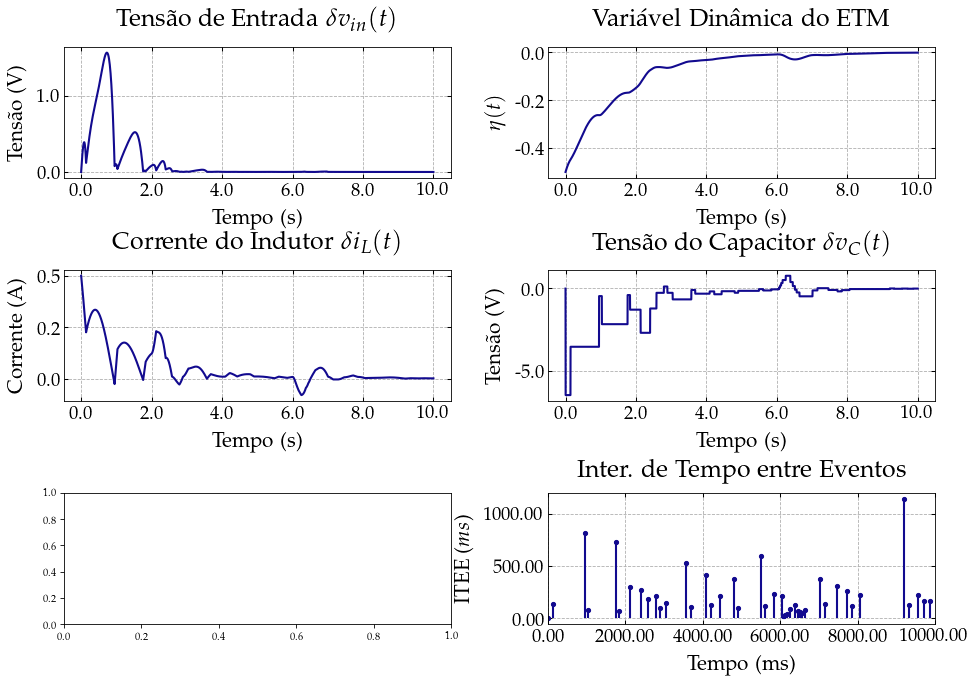

In [ ]:
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.25, hspace=.7)


plot_utils.set_subplot(
    axs[0][0],
    t, y[0],
    'Tempo (s)',
    'Tensão (V)',
    'Tensão de Entrada $\\delta v_{in}(t)$',
)

plot_utils.set_subplot(
    axs[0][1],
    t, y[1],
    'Tempo (s)',
    '$\\eta(t)$',
    'Variável Dinâmica do ETM',
)

plot_utils.set_subplot(
    axs[1][0],
    t, y[2],
    'Tempo (s)',
    'Corrente (A)',
    'Corrente do Indutor $\\delta i_L(t)$',
)

plot_utils.set_subplot(
    axs[1][1],
    t, y[3],
    'Tempo (s)',
    'Tensão (V)',
    'Tensão do Capacitor $\\delta v_C(t)$',
)

# plot_utils.set_subplot(
#     axs[2][0],
#     t,
#     y[2],
#     'Tempo (ms)',
#     '$\\textit{Duty} \\; \\textit{cycle}$',
#     '$\\textit{Duty} \\; \\textit{cycle}$ $\\delta d(t)$',
#     y_digits=2
# )

print(sum(inter_event_times))

plot_utils.set_stem(
    axs[2][1], [et * 1e3 for et in etm.event_times],
    [et * 1e3 for et in inter_event_times],
    xlabel='Tempo (ms)', ylabel='ITEE ($ms$)',
    x_digits=2,
    x_min=0.,
    x_max=end_time * 1e3,
    title='Inter. de Tempo entre Eventos')